In [18]:
import matplotlib.pyplot as plt
import numpy as np

开始pytorch使用
-------------------
- 尝试numpy实现dnn
- 换成pytorch实现dnn

nerual network代码实现
----------------
- numpy 实现版本

In [19]:
def relu(inp):
    zeros = np.zeros(inp.shape)
    out = np.maximum(zeros, inp)
    return out

In [20]:
def sigmoid(inp):
    return 1/(1+np.exp(-inp))

In [21]:
'''
    考虑最近adam在非凸优化时更具鲁棒性并且收敛速度快
    在这里我实现两个优化器 SGD / ADAM
    由于深层神经网络比较复杂，我这里就只实现双层
    
    ps：这里实现的是回归版本，如果换成分类版本，
    只需要将loss换成交叉熵，并且output的
    activation function换成sigmoid或者softmax
'''
class Nerual_Network(object):
    def __init__(self, hidden_size=100, penalty='null', learning_rate=0.01, iteration=200, lamda=0.1, solver='gradient', activation='sigmoid'):
        self.hidden_size = hidden_size
        self.penalty = penalty
        self.learning_rate = learning_rate
        self.iteration = iteration
        self.lamda = lamda
        self.solver = solver
        self.activation = activation
        self.W1 = None
        self.W2 = None
        self.b1 = None
        self.b2 = None
    
    def fit(self, X, y):
        if self.solver == 'gradient':
            costs = self.bp_gradient(X, y)
            return costs
        elif self.solver == 'adam':
            costs = self.bp_adam(X, y)
            return costs
    
    def compute_cost(self, X, y, W1, W2, b1, b2):
        m = X.shape[0]
        out = None
        cost = None
        if self.activation == 'sigmoid':
             out = W2@sigmoid(W1@X.T + b1) + b2
        elif self.activation == 'relu':
             out = W2@relu(W1@X.T + b1) + b2
        cost = np.sum((out.T-y)**2)/(2*m)        
        
        penalty = 0
        if self.penalty == 'l2':
            penalty = 1/(2*m) * self.lamda * (np.sum(W1**2) + np.sum(W2**2))
        elif self.penalty == 'l1':
            penalty = 1/m * self.lamda * (np.sum(np.abs(W1)) + np.sum(np.abs(W2)))
            
        return cost + penalty
            
            
    def bp_gradient(self, X, y):
        W1 = np.random.randn(self.hidden_size, X.shape[1]) * 0.01
        W2 = np.random.randn(y.shape[1], self.hidden_size) * 0.01
        b1 = np.zeros((self.hidden_size, 1))
        b2 = np.zeros((y.shape[1], 1))
        m = X.shape[0]
        costs = []
        
        if self.activation == 'sigmoid':
            for i in range(self.iteration):
                # 前向传播，隐藏层全用sigmoid作为激活函数，输出层
                Z1 = W1@X.T + b1 # （hidden_size， m）
                A1 = sigmoid(Z1) #（hidden_size， m）
                Z2 = W2@A1 + b2 # (y.shape[1], m)
                A2 = Z2.T # (m， y.shape[1]) 
                
                # 反向传播，链式法则
                penalty_W2 = 0
                penalty_W1 = 0
                if self.penalty == 'l2':
                    penalty_W2 = self.lamda * W2
                    penalty_W1 = self.lamda * W1
                elif self.penalty == 'l1':
                    W2_bac = np.sign(W2)
                    penalty_W2 = self.lamda * W2_bac
                    W1_bac = np.sign(W1)
                    penalty_W1 = self.lamda * W1_bac
                W2 -= self.learning_rate * (((A2-y)/m).T@A1.T + penalty_W2)
                b2 -= self.learning_rate * np.sum(((A2-y)/m).T, axis=1, keepdims=True)
                W1 -= self.learning_rate * (W2.T@((A2-y)/m).T*(A1*(1-A1))@X + penalty_W1)
                b1 -= self.learning_rate * np.sum(W2.T@((A2-y)/m).T*(A1*(1-A1)), axis=1, keepdims=True)
                costs.append(self.compute_cost(X,y,W1,W2,b1,b2))
            self.W1 = W1
            self.W2 = W2
            self.b1 = b1
            self.b2 = b2
            
            return costs
        elif self.activation == 'relu':
            for i in range(self.iteration):
                # 前向传播，隐藏层全用relu作为激活函数，输出层
                Z1 = W1@X.T + b1 # （hidden_size， m）
                A1 = relu(Z1) #（hidden_size， m）
                Z2 = W2@A1 + b2 # (y.shape[1], m)
                A2 = Z2.T # (m， y.shape[1]) 
                
                # 反向传播，链式法则
                penalty_W2 = 0
                penalty_W1 = 0
                if self.penalty == 'l2':
                    penalty_W2 = self.lamda * W2
                    penalty_W1 = self.lamda * W1
                elif self.penalty == 'l1':
                    W2_bac = np.sign(W2)
                    penalty_W2 = self.lamda * W2_bac
                    W1_bac = np.sign(W1)
                    penalty_W1 = self.lamda * W1_bac
                W2 -= self.learning_rate * (((A2-y)/m).T@A1.T + penalty_W2)
                b2 -= self.learning_rate * np.sum(((A2-y)/m).T, axis=1, keepdims=True)
                grad_relu = A1.copy()
                grad_relu[grad_relu>0] = 1
                W1 -= self.learning_rate * (W2.T@((A2-y)/m).T*(grad_relu)@X + penalty_W1)
                b1 -= self.learning_rate * np.sum(W2.T@((A2-y)/m).T*(grad_relu), axis=1, keepdims=True)
                costs.append(self.compute_cost(X,y,W1,W2,b1,b2))
            self.W1 = W1
            self.W2 = W2
            self.b1 = b1
            self.b2 = b2
            
            return costs
                
    def bp_adam(self, X, y, beta1=0.5, beta2=0.5,E=1e-8):
        # w参数随机初始化（不要让初始化的值过大）,b初始为0矩阵
        W1 = np.random.randn(self.hidden_size, X.shape[1]) * 0.01
        W2 = np.random.randn(y.shape[1], self.hidden_size) * 0.01
        b1 = np.zeros((self.hidden_size, 1))
        b2 = np.zeros((y.shape[1], 1))
        # 动量1st初始化
        m_W1 = np.zeros((self.hidden_size, X.shape[1]))
        m_W2 = np.zeros((y.shape[1], self.hidden_size))
        m_b1 = np.zeros((self.hidden_size, 1))
        m_b2 = np.zeros((y.shape[1], 1))
        # 动量2nd初始化
        v_W1 = np.zeros((self.hidden_size, X.shape[1]))
        v_W2 = np.zeros((y.shape[1], self.hidden_size))
        v_b1 = np.zeros((self.hidden_size, 1))
        v_b2 = np.zeros((y.shape[1], 1))
        m = X.shape[0]
        costs = []
        
        if self.activation == 'sigmoid':
            for i in range(1, self.iteration+1):
                # 前向传播，隐藏层全用sigmoid作为激活函数，输出层
                Z1 = W1@X.T + b1 # （hidden_size， m）
                A1 = sigmoid(Z1) #（hidden_size， m）
                Z2 = W2@A1 + b2 # (y.shape[1], m)
                A2 = Z2.T # (m， y.shape[1]) 
                
                # 反向传播，链式法则
                penalty_W2 = 0
                penalty_W1 = 0
                if self.penalty == 'l2':
                    penalty_W2 = self.lamda * W2
                    penalty_W1 = self.lamda * W1
                elif self.penalty == 'l1':
                    W2_bac = np.sign(W2)
                    penalty_W2 = self.lamda * W2_bac
                    W1_bac = np.sign(W1)
                    penalty_W1 = self.lamda * W1_bac
                grad_W2 = ((A2-y)/m).T@A1.T + penalty_W2
                m_W2 = (beta1*m_W2 + (1-beta1)*grad_W2)/(1-beta1**i)
                v_W2 = (beta2*v_W2 + (1-beta2)*grad_W2**2)/(1-beta2**i)
                W2 -= self.learning_rate * m_W2/(np.sqrt(v_W2)+E)
                
                grad_b2 = np.sum(((A2-y)/m).T, axis=1, keepdims=True)
                m_b2 = (beta1*m_b2 + (1-beta1)*grad_b2)/(1-beta1**i)
                v_b2 = (beta2*v_b2 + (1-beta2)*grad_b2**2)/(1-beta2**i)
                b2 -= self.learning_rate * m_b2/(np.sqrt(v_b2)+E)
                
                grad_W1 = W2.T@((A2-y)/m).T*(A1*(1-A1))@X + penalty_W1
                m_W1 = (beta1*m_W1 + (1-beta1)*grad_W1)/(1-beta1**i)
                v_W1 = (beta2*v_W1 + (1-beta2)*grad_W1**2)/(1-beta2**i)
                W1 -= self.learning_rate * m_W1/(np.sqrt(v_W1)+E)
                
                grad_b1 = np.sum(W2.T@((A2-y)/m).T*(A1*(1-A1)), axis=1, keepdims=True)
                m_b1 = (beta1*m_b1 + (1-beta1)*grad_b1)/(1-beta1**i)
                v_b1 = (beta2*v_b1 + (1-beta2)*grad_b1**2)/(1-beta2**i)
                b1 -= self.learning_rate * m_b1/(np.sqrt(v_b1)+E)
                
                costs.append(self.compute_cost(X,y,W1,W2,b1,b2))
                
            self.W1 = W1
            self.W2 = W2
            self.b1 = b1
            self.b2 = b2
            
            return costs
        
        elif self.activation == 'relu':
            for i in range(1, self.iteration+1):
                # 前向传播，隐藏层全用relu作为激活函数，输出层
                Z1 = W1@X.T + b1 # （hidden_size， m）
                A1 = relu(Z1) #（hidden_size， m）
                Z2 = W2@A1 + b2 # (y.shape[1], m)
                A2 = Z2.T # (m， y.shape[1]) 
                
                # 反向传播，链式法则
                penalty_W2 = 0
                penalty_W1 = 0
                if self.penalty == 'l2':
                    penalty_W2 = self.lamda * W2
                    penalty_W1 = self.lamda * W1
                elif self.penalty == 'l1':
                    W2_bac = np.sign(W2)
                    penalty_W2 = self.lamda * W2_bac
                    W1_bac = np.sign(W1)
                    penalty_W1 = self.lamda * W1_bac
                grad_W2 = ((A2-y)/m).T@A1.T + penalty_W2
                m_W2 = (beta1*m_W2 + (1-beta1)*grad_W2)/(1-beta1**i)
                v_W2 = (beta2*v_W2 + (1-beta2)*grad_W2**2)/(1-beta2**i)
                W2 -= self.learning_rate * m_W2/(np.sqrt(v_W2)+E)
                
                grad_b2 = np.sum(((A2-y)/m).T, axis=1, keepdims=True)
                m_b2 = (beta1*m_b2 + (1-beta1)*grad_b2)/(1-beta1**i)
                v_b2 = (beta2*v_b2 + (1-beta2)*grad_b2**2)/(1-beta2**i)
                b2 -= self.learning_rate * m_b2/(np.sqrt(v_b2)+E)
                
                grad_relu = A1.copy()
                grad_relu[grad_relu>0] = 1
                
                grad_W1 = W2.T@((A2-y)/m).T*(grad_relu)@X + penalty_W1
                m_W1 = (beta1*m_W1 + (1-beta1)*grad_W1)/(1-beta1**i)
                v_W1 = (beta2*v_W1 + (1-beta2)*grad_W1**2)/(1-beta2**i)
                W1 -= self.learning_rate * m_W1/(np.sqrt(v_W1)+E)
                
                grad_b1 = np.sum(W2.T@((A2-y)/m).T*(grad_relu), axis=1, keepdims=True)
                m_b1 = (beta1*m_b1 + (1-beta1)*grad_b1)/(1-beta1**i)
                v_b1 = (beta2*v_b1 + (1-beta2)*grad_b1**2)/(1-beta2**i)
                b1 -= self.learning_rate * m_b1/(np.sqrt(v_b1)+E)
                
                costs.append(self.compute_cost(X,y,W1,W2,b1,b2))
                
            self.W1 = W1
            self.W2 = W2
            self.b1 = b1
            self.b2 = b2
            
            return costs

    
    def predict(self, X):
        if self.activation == 'sigmoid':
            Z1 = self.W1@X.T + self.b1
            A1 = sigmoid(Z1) 
            Z2 = self.W2@A1 + self.b2
            A2 = Z2.T
            return A2
        elif self.activation == 'relu':
            Z1 = self.W1@X.T + self.b1
            A1 = relu(Z1) 
            Z2 = self.W2@A1 + self.b2
            A2 = Z2.T
            return A2

test 部分

In [22]:
X = np.array([[1,1],
     [2,2],
     [3,3],
     [4,4]])
y = np.array([[1],
     [2],
     [3],
     [4]])

In [23]:
nerual = Nerual_Network(activation='sigmoid',learning_rate=0.001, iteration=300,solver='gradient')
costs1 = nerual.fit(X, y)
costs1 = [float(cost) for cost in costs1]

nerual = Nerual_Network(activation='relu',learning_rate=0.001, iteration=300,solver='gradient')
costs2 = nerual.fit(X, y)
costs2 = [float(cost) for cost in costs2]

nerual = Nerual_Network(activation='sigmoid',learning_rate=0.001, iteration=300,solver='adam')
costs3 = nerual.fit(X, y)
costs3 = [float(cost) for cost in costs3]

nerual = Nerual_Network(activation='relu',learning_rate=0.001, iteration=300,solver='adam')
costs4 = nerual.fit(X, y)
costs4 = [float(cost) for cost in costs4]

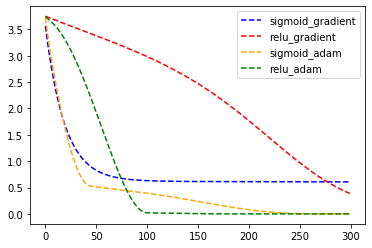

In [24]:
x = np.arange(300)
plt.plot(x, costs1, '--', color='b', label='sigmoid_gradient')
plt.plot(x, costs2, '--', color='r', label='relu_gradient')
plt.plot(x, costs3, '--', color='orange', label='sigmoid_adam')
plt.plot(x, costs4, '--', color='g', label='relu_adam')
plt.legend();

nerual network代码实现
----------------
- pytorch 实现版本

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
N = 1000
in_dim = 32
hidden1_dim = 1000
hidden2_dim = 100
out_dim = 1

In [ ]:
# 随机创建一下输入变量和输出变量
x = torch.rand(N, in_dim).to('cuda')
y = torch.rand(N, out_dim).to('cuda')

In [ ]:
class ThreeLayer(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim, out_dim):
        super(ThreeLayer, self).__init__()
        # architecture
        self.linear_part1 = torch.nn.Linear(in_dim, hidden1_dim, bias=False)
        self.linear_part2 = torch.nn.Linear(hidden1_dim, hidden2_dim, bias=False)
        self.linear_part3 = torch.nn.Linear(hidden2_dim, out_dim, bias=False)
  
    def forward(self, x):
        hidden_output1 = F.relu(self.linear_part1(x))
        hidden_output2 = F.relu(self.linear_part2(hidden_output1))
        output = self.linear_part3(hidden_output2)
        return output

In [ ]:
model = ThreeLayer(in_dim, hidden1_dim, hidden2_dim, out_dim)
model = model.to('cuda')
loss_fn = nn.MSELoss(reduction='sum')
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for it in range(1000):
    # forward pass
    y_pred = model(x)

    # loss function
    loss = loss_fn(y_pred, y)
    print('第{}轮'.format(it), loss.item())

    # 反向传播加更新加梯度清零
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

